In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score,recall_score,f1_score,precision_score
from tensorflow.keras.models import clone_model
from tqdm import tqdm
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
from sklearn.model_selection import train_test_split
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2025-04-17 19:06:44.340266: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744916804.578335      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744916804.653305      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/customer-behavior-dataset/Customer_Behavior_Data.csv
/kaggle/input/ps-dataset/order_data_last_six_month.xlsx - Worksheet.csv
/kaggle/input/ps-dataset/associated_order_item_data_last_six_month.xlsx - Worksheet.csv


In [2]:
def piechart(series):
    """
    Automatically plots a pie chart from a Pandas Series.
    - Uses the series name as the chart title.
    - Displays value counts as percentages.
    """
    if not isinstance(series, pd.Series):
        raise TypeError("Input must be a pandas Series")

    counts = series.value_counts(dropna=False)
    labels = counts.index.astype(str)
    
    # Auto-title using series name or fallback
    title = series.name if series.name else "Pie Chart"

    # Plot
    plt.figure(figsize=(6, 6))
    plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, counterclock=False)
    plt.title(title)
    plt.axis('equal')  # Equal aspect ratio ensures the pie is circular
    plt.show()

In [3]:
beh_data=pd.read_csv("/kaggle/input/customer-behavior-dataset/Customer_Behavior_Data.csv")

In [4]:
zero_people=beh_data[beh_data['Total Orders']<=4]['customer_id']

In [5]:
cluster_1_people=beh_data[((beh_data['Total Orders']<=25) & (beh_data['Total Orders']>4) & (beh_data['Average Order Gap Days']>=14))]['customer_id']

In [6]:
cluster_2_people = beh_data['customer_id'][~beh_data['customer_id'].isin(cluster_1_people) & ~beh_data['customer_id'].isin(zero_people)]

In [7]:
dataset=pd.read_csv("/kaggle/input/ps-dataset/order_data_last_six_month.xlsx - Worksheet.csv")

In [8]:
train_data=dataset[dataset['customer_id'].isin(cluster_1_people)]

In [9]:
train_data.head()

,order_date,order_id,order_number,customer_id,customer_name,poc_name,poc_id,amount,discount,net_order_amount,profit,order_status,warehouse_name,warehouse_id
2,12/02/2025,116427,SO/24-25/96511,3827,Shama chicken corner beta,Yash Pandey,51,62500.0,5000.0,57500.0,-650.0,CLOSED,Noida,3
12,25/01/2025,108509,SO/24-25/89102,2528,Madina Hotel,MAYANK SHEKHAR,23,29120.0,1650.0,27470.0,-376.0,CLOSED,Telibagh,2
22,17/01/2025,104852,SO/24-25/85613,4308,Narayan Bhog,MAYANK SHEKHAR,23,2500.0,220.0,2280.0,-20.0,CLOSED,Telibagh,2
37,18/02/2025,119155,SO/24-25/99068,6080,Gupta General Store,Ashish Bajpai,5397,9000.0,1050.0,7950.0,-150.0,CLOSED,Telibagh,2
40,19/03/2025,130410,SO/24-25/109662,1533,Turkish Delight,Naveen Verma,40,4240.0,280.0,3960.0,-80.0,CLOSED,Gomti Nagar,1


In [10]:
train_data.drop(['order_number','customer_name','poc_name','poc_id','amount','profit','order_status','warehouse_id'],axis=1,inplace=True)

/tmp/ipykernel_19/404819675.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data.drop(['order_number','customer_name','poc_name','poc_id','amount','profit','order_status','warehouse_id'],axis=1,inplace=True)


In [11]:
import pandas as pd

# assume train_data is your original DataFrame
df = train_data.copy()
df['order_date'] = pd.to_datetime(df['order_date'], dayfirst=True)

# group & aggregate:
daily_df = df.groupby(['customer_id','order_date']).agg(
    daily_order_count = ('order_id',       'count'),
    discount          = ('discount',       'sum'),
    net_order_amount  = ('net_order_amount','sum'),
    warehouse_name    = ('warehouse_name', 'first')  # or use mode if you prefer
).reset_index()

# now daily_df has exactly one row per customer per date
daily_df

,customer_id,order_date,daily_order_count,discount,net_order_amount,warehouse_name
0,12,2024-10-01,1,200.0,1660.0,Gomti Nagar
1,12,2024-11-30,1,140.0,1650.0,Gomti Nagar
2,12,2024-12-16,1,110.0,1680.0,Gomti Nagar
3,12,2025-01-04,1,100.0,1690.0,Gomti Nagar
4,12,2025-01-12,1,70.0,1720.0,Gomti Nagar
...,...,...,...,...,...,...
6486,8671,2025-02-06,1,2600.0,30900.0,Gomti Nagar
6487,8671,2025-02-23,1,3700.0,41500.0,Gomti Nagar
6488,8671,2025-03-17,1,3665.0,27250.0,Gomti Nagar
6489,8671,2025-03-26,1,950.0,22950.0,Gomti Nagar


In [12]:
daily_df_dummy=pd.get_dummies(daily_df,columns=['warehouse_name'],dtype='int')

In [13]:
daily_df_dummy

,customer_id,order_date,daily_order_count,discount,net_order_amount,warehouse_name_Ayodhya,warehouse_name_Gomti Nagar,warehouse_name_Greater NOIDA,warehouse_name_Noida,warehouse_name_Telibagh,warehouse_name_Unnao
0,12,2024-10-01,1,200.0,1660.0,0,1,0,0,0,0
1,12,2024-11-30,1,140.0,1650.0,0,1,0,0,0,0
2,12,2024-12-16,1,110.0,1680.0,0,1,0,0,0,0
3,12,2025-01-04,1,100.0,1690.0,0,1,0,0,0,0
4,12,2025-01-12,1,70.0,1720.0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6486,8671,2025-02-06,1,2600.0,30900.0,0,1,0,0,0,0
6487,8671,2025-02-23,1,3700.0,41500.0,0,1,0,0,0,0
6488,8671,2025-03-17,1,3665.0,27250.0,0,1,0,0,0,0
6489,8671,2025-03-26,1,950.0,22950.0,0,1,0,0,0,0


In [14]:
SEQ_LEN = 30
PRED_HORIZON = 14

In [15]:
df = daily_df_dummy.copy()
df['order_date'] = pd.to_datetime(df['order_date'])

# Identify feature columns (everything except customer_id and date)
feature_cols = [c for c in df.columns 
                if c not in ('customer_id','order_date')]

# Container for sequences
X, y = [], []

# Process each customer individually
for cust_id, group in tqdm(df.groupby('customer_id'), total=df['customer_id'].nunique()):
    # 1) build a full daily index for this customer
    group = group.set_index('order_date').sort_index()
    full_idx = pd.date_range(group.index.min(), group.index.max(), freq='D')
    group = group.reindex(full_idx).fillna(0)
    
    # keep customer_id and date for indexing
    group['customer_id'] = cust_id
    group['date']        = group.index
    
    # 2) extract feature matrix and target vector
    data = group[feature_cols].values
    targets = (group['daily_order_count'] > 0).astype(int).values  # 0/1 each day
    
    # 3) sliding windows
    n = len(group)
    for start in range(n - SEQ_LEN - PRED_HORIZON + 1):
        end   = start + SEQ_LEN
        fend  = end + PRED_HORIZON
        
        X.append(data[start:end, :])         # shape (30, num_features)
        y.append(targets[end:fend])          # shape (14,)
        
# 4) convert to numpy arrays
X = np.stack(X)   # (num_samples, 30, num_features)
y = np.stack(y)   # (num_samples, 14)

print("X shape:", X.shape)
print("y shape:", y.shape)

100%|██████████| 847/847 [00:02<00:00, 400.62it/s]


X shape: (86421, 30, 9)
y shape: (86421, 14)


In [16]:
X_train,X_test,Y_train,Y_test=train_test_split(X,y,test_size=0.4,random_state=42)
X_cv,X_test,Y_cv,Y_test=train_test_split(X_test,Y_test,test_size=0.5,random_state=42)

In [17]:
from tensorflow.keras.optimizers import Adam

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Assuming you have already defined:
# SEQ_LEN = 30
# PRED_HORIZON = 14
# feature_cols = [...]  # list of your input column names

NUM_FEATURES = len(feature_cols)

model = Sequential([
    # 1st LSTM layer, returns sequences so we can stack another LSTM
    LSTM(128, input_shape=(SEQ_LEN, NUM_FEATURES), return_sequences=True),
    Dropout(0.2),

    # 2nd LSTM layer
    LSTM(64, return_sequences=False),
    Dropout(0.2),

    # Dense “bottleneck” to learn combined features
    Dense(32, activation='relu'),
    Dropout(0.1),

    # Final output: 14 sigmoid neurons, one per future day
    Dense(PRED_HORIZON, activation='sigmoid')
])

model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

I0000 00:00:1744916821.654494      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1744916821.655311      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 128)             │          70,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 14)                  │             462 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 122,606 (478.93 KB)

 Trainable params: 122,606 (478.93 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:
checkpoint = ModelCheckpoint(
    filepath='best_model.weights.h5',      # Path to save the model weights
    monitor='val_loss',                    # Metric to monitor
    save_best_only=True,                   # Save only the best weights
    save_weights_only=True,                # Save only weights (not full model)
    mode='min',                            # 'min' for loss, 'max' for accuracy
    verbose=1
)

In [20]:
history = model.fit(
    X_train, Y_train,
    epochs=100,
    batch_size=64,
    validation_data=(X_cv, Y_cv),
    callbacks=[checkpoint]  # You can add ModelCheckpoint or EarlyStopping if needed
)

Epoch 1/100


I0000 00:00:1744916827.902379      62 cuda_dnn.cc:529] Loaded cuDNN version 90300


810/811 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0822 - loss: 0.3740
Epoch 1: val_loss improved from inf to 0.17338, saving model to best_model.weights.h5
811/811 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.0823 - loss: 0.3737 - val_accuracy: 0.0308 - val_loss: 0.1734
Epoch 2/100
808/811 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0996 - loss: 0.1918
Epoch 2: val_loss improved from 0.17338 to 0.17182, saving model to best_model.weights.h5
811/811 ━━━━━━━━━━━━━━━━━━━━ 7s 8ms/step - accuracy: 0.0996 - loss: 0.1918 - val_accuracy: 0.0308 - val_loss: 0.1718
Epoch 3/100
811/811 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.0848 - loss: 0.1841
Epoch 3: val_loss improved from 0.17182 to 0.17164, saving model to best_model.weights.h5
811/811 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.0848 - loss: 0.1841 - val_accuracy: 0.0308 - val_loss: 0.1716
Epoch 4/100
810/811 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.0761 - loss: 0.1797
Epoch 4: val_loss improved from 0.17164 to 0.1

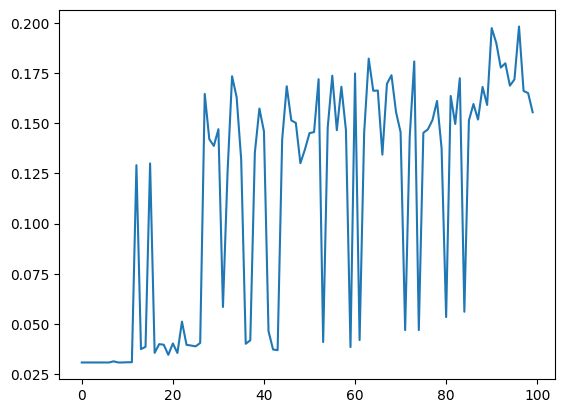

In [21]:
plt.plot(history.history['val_accuracy'])

In [22]:
pred_train=model.predict(X_train)
pred_train_bin= (pred_train > 0.5).astype(int)
print("Training Data:")

print("Accuracy is ",accuracy_score(Y_train,pred_train_bin))
print("Precision is ",precision_score(Y_train,pred_train_bin,average='macro'))
print("Recall is ",recall_score(Y_train,pred_train_bin,average='macro'))
print("F1 Score is ",f1_score(Y_train,pred_train_bin,average='macro'))

pred_val=model.predict(X_cv)
pred_val_bin= (pred_val > 0.5).astype(int)
print("Validation Data:")

print("Accuracy is ",accuracy_score(Y_cv,pred_val_bin))
print("Precision is ",precision_score(Y_cv,pred_val_bin,average='macro'))
print("Recall is ",recall_score(Y_cv,pred_val_bin,average='macro'))
print("F1 Score is ",f1_score(Y_cv,pred_val_bin,average='macro'))


1621/1621 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Training Data:
Accuracy is  0.5192856591838308
Precision is  0.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall is  0.0
F1 Score is  0.0
541/541 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Validation Data:
Accuracy is  0.5150428141633882
Precision is  0.0
Recall is  0.0
F1 Score is  0.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:

model_best = clone_model(model)

# Important: you need to compile it again
model_best.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# Load the best saved weights
model_best.load_weights('best_model.weights.h5')
pred_val=model_best.predict(X_cv)
pred_val_bin= (pred_val > 0.5).astype(int)
pred_train=model_best.predict(X_train)
pred_train_bin= (pred_train> 0.5).astype(int)
print("Training Data:")

print("Accuracy is ",accuracy_score(Y_train,pred_train_bin))
print("Precision is ",precision_score(Y_train,pred_train_bin,average='macro'))
print("Recall is ",recall_score(Y_train,pred_train_bin,average='macro'))
print("F1 Score is ",f1_score(Y_train,pred_train_bin,average='macro'))

print("Validation Data:")

print("Accuracy is ",accuracy_score(Y_cv,pred_val_bin))
print("Precision is ",precision_score(Y_cv,pred_val_bin,average='macro'))
print("Recall is ",recall_score(Y_cv,pred_val_bin,average='macro'))
print("F1 Score is ",f1_score(Y_cv,pred_val_bin,average='macro'))


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


541/541 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step
1621/1621 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
Training Data:
Accuracy is  0.5192856591838308
Precision is  0.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall is  0.0
F1 Score is  0.0
Validation Data:
Accuracy is  0.5150428141633882
Precision is  0.0
Recall is  0.0
F1 Score is  0.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
